## GoingDeeperCv <br/> - 4. 없다면 어떻게 될까?

## 1. Augmentation을 적용한 데이터셋 제작

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# 공개되어 있는 많은 데이터셋들의 원본을 tfds 모듈로 불러들일 수 있다.
import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

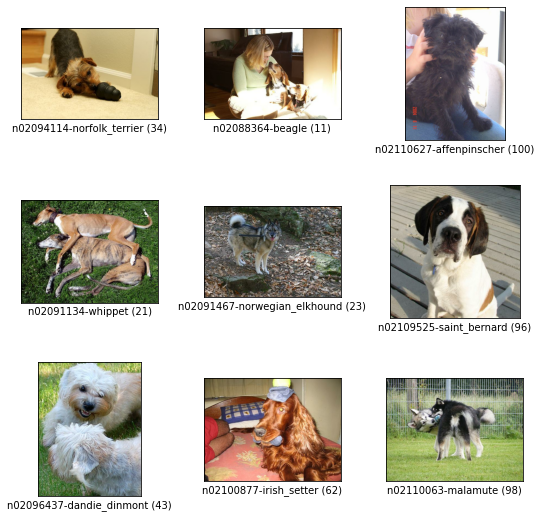

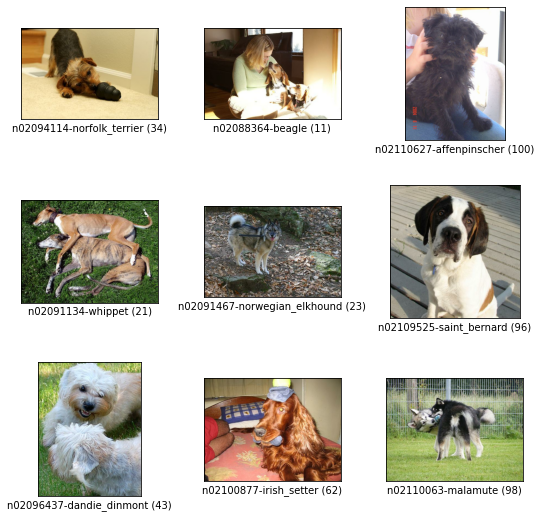

In [4]:
tfds.show_examples(ds_train, ds_info)

#### 1-1. Augmentation

#### 바로 사용할 수 있는 텐서플로우 Random Augmentation API
- random_brightness() : 명도조절
- random_contrast() : 대비
- random_crop() : 이미지를 대상 높이와 너비에 맞게 무작위로 자름.
- random_flip_left_right() : 좌우대칭
- random_flip_up_down() : 상하대칭
- random_hue() : 색상조절
- random_jpeg_quality() : 
- random_saturation() : 채도조절

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

#### 1-2. CutMix Augmentation

- 논문 : https://arxiv.org/pdf/1905.04899.pdf 
- 요약 : https://deep-learning-study.tistory.com/633
        
        이미지의 일정 영역을 잘라서 다른 이미지에 붙여주는 방법.
        
        모델이 객체의 차이를 식별할 수 있는 부분에 집중하지 않고,
        덜 구별되는 부분 및 이미지의 전체적인 구역을 보고 학습도록 하여 
        일반화와 localization 성능을 높이는 방법.
        
        classification, localization, detection 세가지 task에 좋은 성능
        


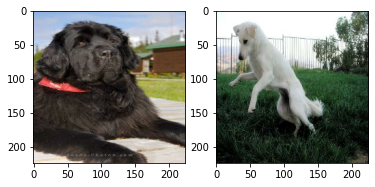

In [9]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [10]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [11]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(63, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(8, shape=(), dtype=int32) tf.Tensor(198, shape=(), dtype=int32)


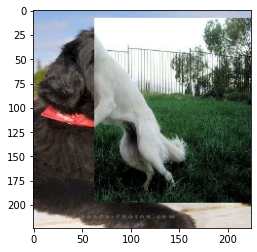

In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [13]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.609654,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.     

In [14]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### 1-3. Mixup Augmentation
- 논문 : https://arxiv.org/pdf/1710.09412.pdf
- 요약 : https://everyday-image-processing.tistory.com/145
        
        두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식.
        해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다.

In [15]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

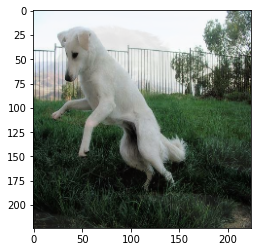

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.8948045
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.  

In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [17]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### 1-4. 데이터셋 제작

In [18]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [19]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

---
---

## 2. 모델제작

#### 2-1. No  Augmentation
    모델은 ResNet-50을 사용

In [21]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

#### 2-2. Augmentation

In [22]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### 2-3. CutMix Augmentation

In [23]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### 2-4. Mixup Augmentation

In [24]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

---
---

## 3. 모델훈련

In [25]:
EPOCH = 20
tf.random.set_seed(2705)

no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

#### 3-1. No Augmentation

In [26]:
his_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 375s 458ms/step - loss: 3.2211 - accuracy: 0.2811 - val_loss: 3.6847 - val_accuracy: 0.1631
Epoch 2/20
750/750 [==============================] - 346s 462ms/step - loss: 0.8716 - accuracy: 0.7612 - val_loss: 1.1655 - val_accuracy: 0.6623
Epoch 3/20
750/750 [==============================] - 347s 463ms/step - loss: 0.3503 - accuracy: 0.9162 - val_loss: 0.9546 - val_accuracy: 0.7168
Epoch 4/20
750/750 [==============================] - 347s 462ms/step - loss: 0.1014 - accuracy: 0.9876 - val_loss: 0.9274 - val_accuracy: 0.7324
Epoch 5/20
750/750 [==============================] - 346s 462ms/step - loss: 0.0338 - accuracy: 0.9979 - val_loss: 0.9304 - val_accuracy: 0.7351
Epoch 6/20
750/750 [==============================] - 346s 462ms/step - loss: 0.0186 - accuracy: 0.9995 - val_loss: 0.9376 - val_accuracy: 0.7385
Epoch 7/20
750/750 [==============================] - 347s 462ms/step - loss: 0.0126 - accuracy: 0.9999 - val_loss: 0.9445 -

#### 3-2. Augmentation

In [27]:
his_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 354s 462ms/step - loss: 3.3103 - accuracy: 0.2567 - val_loss: 2.9712 - val_accuracy: 0.2736
Epoch 2/20
750/750 [==============================] - 346s 462ms/step - loss: 1.2235 - accuracy: 0.6489 - val_loss: 1.1574 - val_accuracy: 0.6642
Epoch 3/20
750/750 [==============================] - 346s 462ms/step - loss: 0.7005 - accuracy: 0.7999 - val_loss: 1.1889 - val_accuracy: 0.6553
Epoch 4/20
750/750 [==============================] - 346s 461ms/step - loss: 0.4089 - accuracy: 0.8892 - val_loss: 1.0652 - val_accuracy: 0.6845
Epoch 5/20
750/750 [==============================] - 346s 461ms/step - loss: 0.2209 - accuracy: 0.9489 - val_loss: 1.1169 - val_accuracy: 0.6811
Epoch 6/20
750/750 [==============================] - 346s 462ms/step - loss: 0.1254 - accuracy: 0.9783 - val_loss: 0.9965 - val_accuracy: 0.7190
Epoch 7/20
750/750 [==============================] - 346s 461ms/step - loss: 0.0740 - accuracy: 0.9897 - val_loss: 1.0272 -

#### 3-3. CutMix Augmentation

In [28]:
his_cutmix_aug_resnet50 = cutmix_aug_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 355s 465ms/step - loss: 4.3539 - accuracy: 0.1137 - val_loss: 3.1706 - val_accuracy: 0.2287
Epoch 2/20
750/750 [==============================] - 348s 463ms/step - loss: 3.0374 - accuracy: 0.4009 - val_loss: 1.4630 - val_accuracy: 0.6084
Epoch 3/20
750/750 [==============================] - 347s 463ms/step - loss: 2.6915 - accuracy: 0.5148 - val_loss: 1.2880 - val_accuracy: 0.6459
Epoch 4/20
750/750 [==============================] - 348s 464ms/step - loss: 2.4561 - accuracy: 0.5970 - val_loss: 1.1498 - val_accuracy: 0.6812
Epoch 5/20
750/750 [==============================] - 347s 463ms/step - loss: 2.3209 - accuracy: 0.6454 - val_loss: 1.1325 - val_accuracy: 0.6845
Epoch 6/20
750/750 [==============================] - 347s 463ms/step - loss: 2.1863 - accuracy: 0.6678 - val_loss: 1.3457 - val_accuracy: 0.6298
Epoch 7/20
750/750 [==============================] - 348s 464ms/step - loss: 2.1015 - accuracy: 0.6954 - val_loss: 1.2575 -

#### 3-4. Mixup Augmentation

In [30]:
his_mixup_aug_resnet50 = mixup_aug_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 348s 462ms/step - loss: 0.1548 - accuracy: 0.9741 - val_loss: 1.0547 - val_accuracy: 0.6957
Epoch 2/20
750/750 [==============================] - 347s 462ms/step - loss: 0.0672 - accuracy: 0.9922 - val_loss: 0.9158 - val_accuracy: 0.7406
Epoch 3/20
750/750 [==============================] - 347s 462ms/step - loss: 0.0279 - accuracy: 0.9979 - val_loss: 0.9262 - val_accuracy: 0.7453
Epoch 4/20
750/750 [==============================] - 347s 462ms/step - loss: 0.0129 - accuracy: 0.9998 - val_loss: 0.9162 - val_accuracy: 0.7494
Epoch 5/20
750/750 [==============================] - 347s 462ms/step - loss: 0.0095 - accuracy: 0.9997 - val_loss: 0.9361 - val_accuracy: 0.7424
Epoch 6/20
750/750 [==============================] - 346s 461ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.9432 - val_accuracy: 0.7451
Epoch 8/20
750/750 [==============================] - 346s 462ms/step - loss: 0.0053 - accuracy: 0.9999 - val_loss: 0.9490 -

---
---

## 5. 시각화

#### 5-1. Accuracy

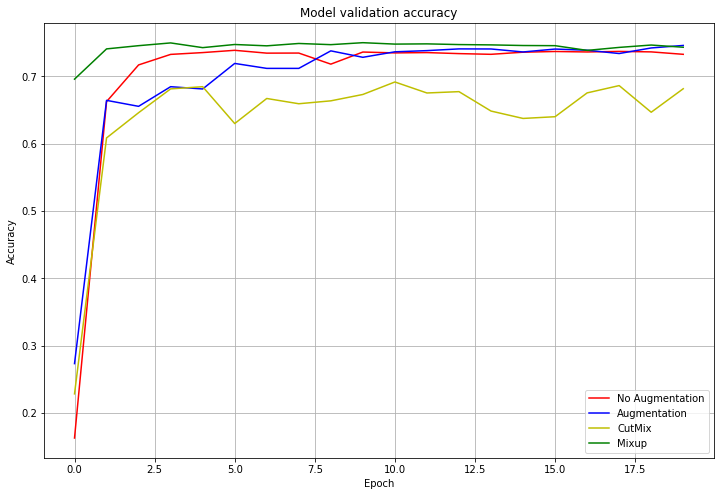

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(his_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(his_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(his_cutmix_aug_resnet50.history['val_accuracy'], 'y')
plt.plot(his_mixup_aug_resnet50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='lower right')
plt.grid(True)
plt.show()

#### 5-2. Loss

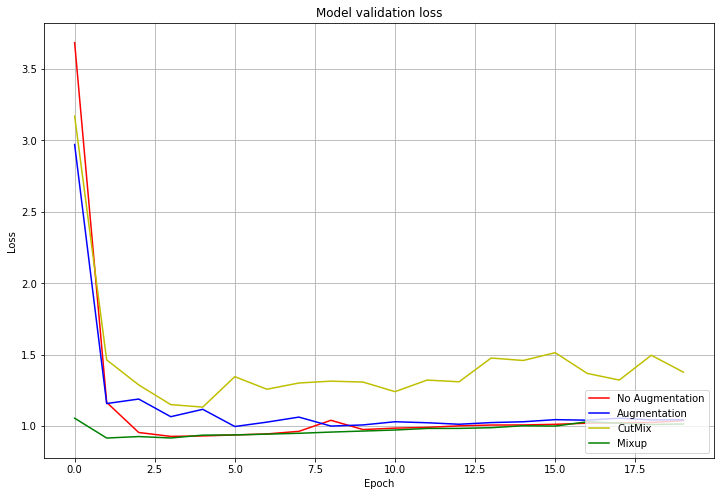

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(his_no_aug_resnet50.history['val_loss'], 'r')
plt.plot(his_aug_resnet50.history['val_loss'], 'b')
plt.plot(his_cutmix_aug_resnet50.history['val_loss'], 'y')
plt.plot(his_mixup_aug_resnet50.history['val_loss'], 'g')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='lower right')
plt.grid(True)
plt.show()

---
---

## 성능비교

In [33]:
import pandas as pd

In [35]:
acc_data = {'No Augmentation': his_no_aug_resnet50.history['val_accuracy'], 
            'Augmentation': his_aug_resnet50.history['val_accuracy'], 
            'CutMix': his_cutmix_aug_resnet50.history['val_accuracy'], 
            'Mixup': his_mixup_aug_resnet50.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,Augmentation,CutMix,Mixup
0,0.163130,0.273554,0.228661,0.695662
1,0.662313,0.664179,0.608442,0.740555
2,0.716768,0.655317,0.645872,0.745336
3,0.732393,0.684468,0.681203,0.749417
4,0.735075,0.681087,0.684468,0.742421
5,0.738456,0.718983,0.629781,0.747085
6,0.734258,0.711637,0.666978,0.745103
7,0.734375,0.711637,0.659165,0.748601
8,0.717934,0.737640,0.663480,0.746852
9,0.735891,0.728078,0.672924,0.749767


- EPOCH = 20으로 'No Augmentation', 'Augmentation', 'CutMix', 'Mixup' 4개를 돌려야 하는데
<br/> 시간이 하나당 평균 2시간씩걸렸다.. 너무 오래 걸린다. ~~커널도 자주 팅기는데~~
- 모든 훈련을 ds_train으로 돌려 다시 8시간으로 돌렸다..


- 대부분 비슷한 accuracy를 가지지만 Augmentation 젤 높다.
- Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인하였다.
- CutMix, MixUp중에선 MixUp이 성능이 좋다.


- 시간이 전반적으로 너무 오래걸려서 힘들었다.